In [7]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import SMA, GOOG
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
#from numba import njit

![Alt text](image-1.png)

In [8]:
# create datafrane
df_fesx = pd.read_csv("./data/fesx_M15_2020-06-20_F.US.DSXM20.scid_BarData.txt", sep=", ", engine = "python")

# create datetime column
df_fesx["Datetime"] = pd.to_datetime(df_fesx.Date + "-" + df_fesx.Time,format="%Y/%m/%d-%H:%M:%S")

# Select columns and raname column "Last" to "Close"
df_fesx = df_fesx[['Datetime','Open', 'High', 'Low', 'Last', 'Volume']].rename(columns={"Last":"Close"})#.set_index("Datetime")

df_fesx.reset_index(inplace=True)
df_fesx.head()

,index,Datetime,Open,High,Low,Close,Volume
0,0,2020-05-21 02:15:00,2917,2921,2916,2918,837
1,1,2020-05-21 02:30:00,2917,2921,2916,2920,354
2,2,2020-05-21 02:45:00,2921,2922,2920,2920,213
3,3,2020-05-21 03:00:00,2920,2920,2915,2919,293
4,4,2020-05-21 03:15:00,2919,2919,2916,2917,511


In [9]:
# Calculate the difference between the high from one point to the previous one
# This will be used to detect the waves
df_fesx['diff_high'] = df_fesx['High'].diff()
df_fesx.head()

,index,Datetime,Open,High,Low,Close,Volume,diff_high
0,0,2020-05-21 02:15:00,2917,2921,2916,2918,837,NaN
1,1,2020-05-21 02:30:00,2917,2921,2916,2920,354,0.0
2,2,2020-05-21 02:45:00,2921,2922,2920,2920,213,1.0
3,3,2020-05-21 03:00:00,2920,2920,2915,2919,293,-2.0
4,4,2020-05-21 03:15:00,2919,2919,2916,2917,511,-1.0


In [10]:
# @njit()
def monotonic_segment(high_diff, th = 2):
    """
    Detects the monotonic segments in the high_diff array
    params:
        high_diff: array of the difference between the high from one point to the previous one
        th: minimum number of consequtive monoton datas to be considered as a segment
    """
    state_high = 0 # Indicate if the high is raising or not. Initial state is 0 (not raising)
    counter_high = 0 # Count the number of consequtive monoton datas for the segment

    segs_high = np.zeros((2,int(high_diff.shape[0]))) # Array of segments with start and end indexes for the segments of monoton high

    seg_idx_high = 0 # Index of the segment in segs_high

    for idx in range(high_diff.shape[0]): # Loop over the high_diff array
        
        # There are two variables to keep track of the indexes:
            # idx: index of the high_diff array
            # seg_idx_high: index of the segs_high array

        high_diff_value = high_diff[idx] # Value of the high_diff at the current index

        if state_high == 0: # state_high was 0 => high was not raising 
            if high_diff_value >= 0: # high is now  raising
                # state_high was 0, now it is 1 => counter_high = 1
                state_high = 1
                counter_high = 1
            else:
                # state_high was 0, and high is still not raising => do nothing
                pass  
        else:
            if high_diff_value >= 0:
                # state_high was 1 already and it's still raising => counter_high += 1
                counter_high += 1
            elif counter_high >= th:
                # state_high was 1 already, high is not raising anymore and counter_high >= th => add segment and reset state_high
                segs_high[0,seg_idx_high] = idx - counter_high -1
                segs_high[1,seg_idx_high] = idx - 1
                seg_idx_high += 1
                state_high = 0
            else:
                # state_high was 1, high is not raising anymore and counter_high < th => reset state_high
                state_high = 0
    
    # return array of segments
    return segs_high[:,:seg_idx_high]




def merge_segs(segs_high):
    """
    Merge the segments if min_value_junction (the lowest high between two segments) is higher than min_value_merge.
    When iterating over the segments, min_value_merge is defined as the value of the start of the segment (lowest point). When a merge happens, min_value_merge is updated to min_value_junction and the merge continues.
    If a merge doesn't happen, we simply add the segment to the merged_segs array and 
    min_value_merge is updated to the start of the next segment.
    """

    merged_segs = np.zeros((2,segs_high.shape[1])) # Array of segments with start and end indexes for merged segments of monoton high

    merged_idx = 0 # Index of the merged segment in merged_segs
    
    seg_idx = 0 # Index of the segment in segs_high

    is_merging = False  # Indicate if we are already merging segments or not

    while True:
        if not is_merging:
            # If we are not already merging segments, we need to set the start_idx of the segment
            start_idx = segs_high[0, seg_idx] # start_idx is the start of the segment
            merged_segs[0, merged_idx] = start_idx # Add start_idx to the merged_segs array
            min_value_merge = df_fesx.loc[start_idx].Low.min() # Initialize min_value_merge to the lowest point of the segment

        merged_segs[1, merged_idx] = segs_high[1, seg_idx] # Add the end of the segment to the merged_segs array. We just added a segment to the merged_segs array and if a merge happens, we will update the end of the segment in the merged_segs array.


        seg_idx += 1 # Increment seg_idx to go to the next segment
        if seg_idx == merged_segs.shape[1]: # If seg_idx is equal to the number of segments, we had included all the segments in the merged_segs array and we can break the loop
             break
        current_line_end_idx = (segs_high[0, seg_idx]) # index of begin of the current segment

        previous_line_begin_idx = (segs_high[1, seg_idx-1]) # index of end of the previous segment

        min_value_junction = df_fesx.loc[previous_line_begin_idx:current_line_end_idx].Low.min() # lowest point between the two segments

        if min_value_junction > min_value_merge:
            merged_segs[1, merged_idx] = segs_high[1, seg_idx] # Update the end of the segment in the merged_segs array
            is_merging = True # We are now merging segments
            min_value_merge = min_value_junction # Update min_value_merge to the lowest point between the two segments
        else: 
            merged_idx += 1 
            is_merging = False
    return merged_segs[:,:merged_idx]


segs_high = monotonic_segment(df_fesx.diff_high.to_numpy())
segs_high = np.ndarray.astype(segs_high, int)
segs_merged = merge_segs(segs_high)

In [11]:
body_len = (df_fesx.Open - df_fesx.Close).abs()

upper_shadow_green = (df_fesx.High - df_fesx.Close)
upper_shadow_red = (df_fesx.High - df_fesx.Open)

lower_shadow_green = (df_fesx.Open - df_fesx.Low)
lower_shadow_red = (df_fesx.Close - df_fesx.Low)

mask_green = df_fesx.Close > df_fesx.Open
mask_red = df_fesx.Close < df_fesx.Open

mask_hammer_green = (lower_shadow_green >= 3*body_len) & (upper_shadow_green <= 0.25 * body_len)  & mask_green
mask_hammer_red = (lower_shadow_red >= 3*body_len) & (upper_shadow_red <= 0.25 * body_len)  & mask_red

In [12]:
fig = go.Figure(data= [
    go.Scatter(x=df_fesx.index, y=df_fesx.High,name = 'High',mode="lines+markers", marker_color = "green",visible="legendonly"),
    go.Scatter(x=df_fesx.index, y=df_fesx.Low,name = 'Low',mode="lines+markers", marker_color = "red", visible="legendonly"),
    go.Scatter(x=df_fesx.index, y=df_fesx.Close,name = 'Close',mode="lines+markers", marker_color = "black", visible="legendonly"),
    
    go.Candlestick(x=df_fesx.index,
                open=df_fesx['Open'],
                high=df_fesx['High'],
                low=df_fesx['Low'],
                close=df_fesx['Close'],
                name = 'Candlestick'
                )
    ]
    )

fig.update_layout(
    xaxis_rangeslider_visible= False
)
for seg_idx in range(segs_high.shape[1]):
    start_idx = int(segs_high[0,seg_idx])
    end_idx = int(segs_high[1,seg_idx] )
    start_wave = df_fesx.loc[start_idx, "High"]
    end_wave = df_fesx.loc[end_idx, "High"]
    fig.add_trace(
    go.Scatter(x=[start_idx, end_idx], y=[start_wave, end_wave],name = "High",mode="lines", marker_color = 'blue',legendgroup="High", showlegend=False)
    )      

dict_color = {"High":"purple", "Low":"orange"}


for seg_idx in range(segs_merged.shape[1]):
    start_idx = int(segs_merged[0,seg_idx])
    end_idx = int(segs_merged[1,seg_idx] )
    start_wave = df_fesx.loc[start_idx, "High"]
    end_wave = df_fesx.loc[end_idx, "High"]
    fig.add_trace(
    go.Scatter(x=[start_idx, end_idx], y=[start_wave, end_wave],name = "High",mode="lines", marker_color = 'purple', showlegend=False)
    )


df_peaks = pd.DataFrame(np.transpose(segs_merged), columns=['start_idx', 'end_idx']).astype(int)
df_peaks = df_peaks.merge(df_fesx[['index','High']], left_on='end_idx', right_on='index', how='left')
df_peaks['high_diff'] = df_peaks.High.diff()

for idx, row in df_peaks.iterrows():
    start_idx = row['start_idx']
    end_idx = row['end_idx']
    high = row['High']
    #fig.add_trace(
    #    go.Scatter(x=[start_idx, end_idx], y=[start_wave, end_wave],name = col_name,mode="lines", marker_color = dict_color[col_name], showlegend=False)
    #    )






fig.add_trace(
    go.Scatter(x=df_fesx[mask_hammer_green].index, y = df_fesx[mask_hammer_green].High, name = "Green hammer",mode="markers", marker_color = 'green', showlegend=True)
)

fig.add_trace(
    go.Scatter(x=df_fesx[mask_hammer_red].index, y = df_fesx[mask_hammer_red].High, name = "Red Hammer",mode="markers", marker_color = 'red', showlegend=True)
)





fig.update_layout(height=400, width=1200,
     margin=dict(l=0, r=0, t=20, b=0),             
                  )


#fig.update_xaxes( range=[420, 460])
#fig.update_yaxes( range=[3040, 3100])

fig.show()

# Check 1479
# Check 430

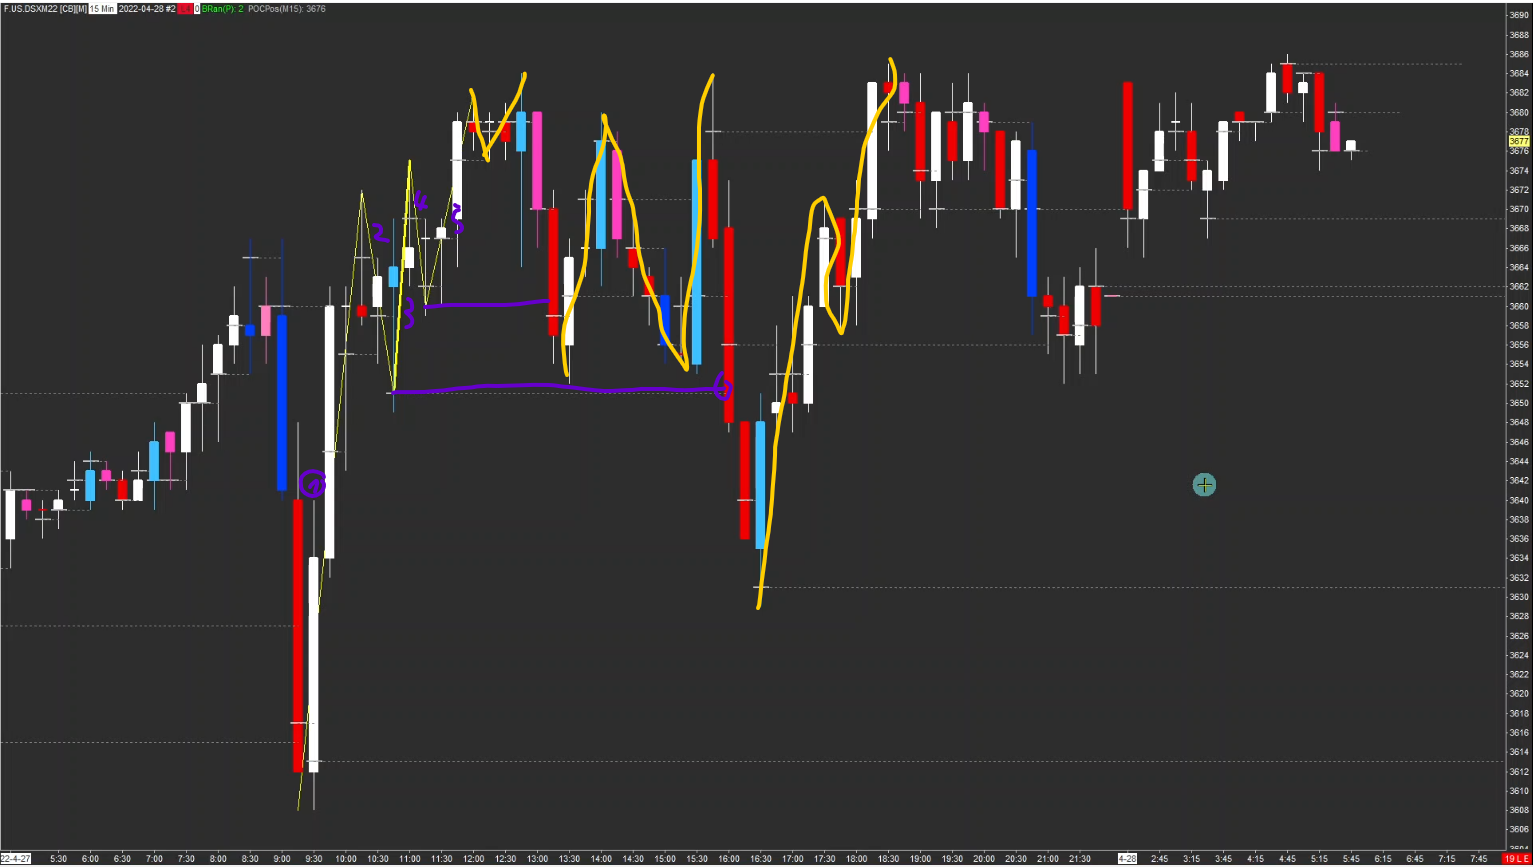